In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# --- Importaciones de sus módulos ---
try:
    from normalization_functions import pipeline_d_normalize
    from lexicon_functions import get_augmented_features
except ImportError:
    sys.path.append('.')
    from normalization_functions import pipeline_d_normalize
    from lexicon_functions import get_augmented_features

# --- Configuración ---
TRAIN_PATH = os.path.join("..", "data", "processed", "train.csv")
TEST_PATH = os.path.join("..", "data", "processed", "test.csv")
RESULTS_DIR = os.path.join("..", "results")

# Los Mejores Hiperparámetros que encontraron
BEST_PARAMS = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'alpha': 0.01,
    'solver': 'adam',
    'random_state': 0,
    'max_iter': 1000 # Asegurar convergencia
}


Recurso 'stopwords' de NLTK ya está descargado.
Cargadas 313 stopwords en español.
Modelo 'es_core_news_sm' de spaCy cargado.


--- FASE 4: ENTRENAMIENTO FINAL ---
Cargando train.csv y test.csv...
Aplicando normalización (Pipeline D)...
Entrenando modelo final con SMOTE + MLP {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.01, 'solver': 'adam', 'random_state': 0, 'max_iter': 1000}...
--- [lexicon_utils] Cargando recursos lingüísticos ---
Generando predicciones sobre el set de prueba (nunca visto)...

RESULTADOS FINALES (TEST SET)
F1-MACRO FINAL: 0.4627

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.39      0.40      0.40       104
           2       0.26      0.25      0.26       145
           3       0.42      0.39      0.40       422
           4       0.42      0.39      0.41      1163
           5       0.84      0.87      0.85      4209

    accuracy                           0.72      6043
   macro avg       0.47      0.46      0.46      6043
weighted avg       0.71      0.72      0.71      6043


Evidencias guardadas en '..\results'

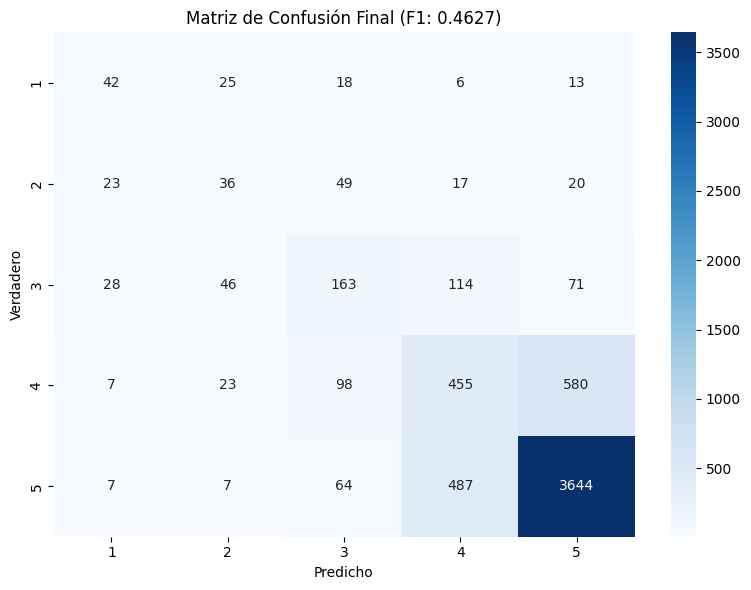

In [2]:

def main():
    print("--- FASE 4: ENTRENAMIENTO FINAL ---")
    
    # 1. Cargar Datos
    print("Cargando train.csv y test.csv...")
    df_train = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)
    
    # 2. Normalización (Pipeline D)
    print("Aplicando normalización (Pipeline D)...")
    X_train = df_train['text'].apply(pipeline_d_normalize)
    y_train = df_train['Polarity']
    
    X_test = df_test['text'].apply(pipeline_d_normalize)
    y_test = df_test['Polarity']
    
    # 3. Construir el Pipeline Final con SMOTE
    # El orden es: Features -> SMOTE -> Modelo
    final_pipeline = ImbPipeline([
        ('features', get_augmented_features()), # FeatureUnion (Texto + Léxicos)
        ('resampler', SMOTE(random_state=0)),   # Balanceo de clases
        ('classifier', MLPClassifier(**BEST_PARAMS)) # Modelo ganador
    ])
    
    # 4. Entrenar con TODO el set de entrenamiento
    print(f"Entrenando modelo final con SMOTE + MLP {BEST_PARAMS}...")
    final_pipeline.fit(X_train, y_train)
    
    # 5. Predecir en el set de Prueba (Test)
    print("Generando predicciones sobre el set de prueba (nunca visto)...")
    y_pred = final_pipeline.predict(X_test)
    
    # 6. Reporte de Resultados Finales
    print("\n" + "="*30)
    print("RESULTADOS FINALES (TEST SET)")
    print("="*30)
    
    # F1-Macro
    final_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1-MACRO FINAL: {final_f1:.4f}")
    
    # Reporte de Clasificación
    print("\nReporte de Clasificación:")
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # 7. Guardar Evidencias
    # Guardar reporte en texto
    with open(os.path.join(RESULTS_DIR, "final_classification_report.txt"), "w") as f:
        f.write(f"F1-MACRO FINAL: {final_f1:.4f}\n\n")
        f.write(report)
    
    # Generar imagen de la Matriz de Confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y_test.unique()), 
                yticklabels=sorted(y_test.unique()))
    plt.title(f'Matriz de Confusión Final (F1: {final_f1:.4f})')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "final_confusion_matrix.png"))
    print(f"\nEvidencias guardadas en '{RESULTS_DIR}'")

if __name__ == "__main__":
    main()